<a href="https://colab.research.google.com/github/cybrBeto/thousandEyesHackday/blob/main/ThousandEyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras.optimizers import SGD
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

# Dataset Loading and EDA

In [ ]:
thousandeyes_df = pd.read_csv( "/content/drive/MyDrive/Colab Notebooks/clients.csv" )

In [ ]:
thousandeyes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279845 entries, 0 to 279844
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   client_mac  279845 non-null  object
 1   date        279845 non-null  object
 2   time        279845 non-null  object
 3   wlan        279845 non-null  object
 4   ap_name     279845 non-null  object
 5   site_tag    279845 non-null  object
 6   location    279845 non-null  int64 
 7   managed     279845 non-null  int64 
 8   mab         279845 non-null  int64 
 9   dot1        279845 non-null  int64 
 10  l3webauth   279845 non-null  int64 
 11  l2webauth   279845 non-null  int64 
 12  username    42237 non-null   object
dtypes: int64(6), object(7)
memory usage: 27.8+ MB


## EDA
- Empty username to be filed with MAC address
- New derived column based on SSID name including "Guest" will be "Privilege"
- aX1 : New derived column "Privilege-score" where guest gets a score of 10 and for the others we give 0. For guest users there is a webauth policy associated.
- bX2 : Check for each username what is the usual MAC address. If this user joins with another MAC address then flag that sample with value "1" otherwise "0". This is "Device-score"
- No changes needed for Managed/Un-managed column
- cX3 : New column "Managed-score" where if managed then 0 and if not managed then 20
- dX4 : Determine the usual time for each username. If usual mark as 0 and if unusual then mark as 1. Column name as "Join-Time-score"
- eX5 : Check if the user joins the usual site tag within office. If yes: 0 else no: 1. We have to check if the site tag is present in one of the logs from the datatset. Column name "AP-join-score"
- fX6 : 3 values for location. Column name "Location-score"
- X7: New column "Security-Factor" = Privilege-score + Device-score +  Managed-score + Join-Time-score + AP-join-score + Location-score
- Y: Classify based on X7 which policy should be applied on the basis of the score calculated.


In [ ]:
# Empty username to be filed with MAC address
# Use fillna to fill column A with values from column B
thousandeyes_df['username'].fillna(thousandeyes_df['client_mac'], inplace=True)

In [ ]:
thousandeyes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279845 entries, 0 to 279844
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   client_mac  279845 non-null  object
 1   date        279845 non-null  object
 2   time        279845 non-null  object
 3   wlan        279845 non-null  object
 4   ap_name     279845 non-null  object
 5   site_tag    279845 non-null  object
 6   location    279845 non-null  int64 
 7   managed     279845 non-null  int64 
 8   mab         279845 non-null  int64 
 9   dot1        279845 non-null  int64 
 10  l3webauth   279845 non-null  int64 
 11  l2webauth   279845 non-null  int64 
 12  username    279845 non-null  object
dtypes: int64(6), object(7)
memory usage: 27.8+ MB


### aX1 : New derived column "Privilege-score" where guest gets a score of 10 and for the others we give 0. For guest users there is a webauth policy associated.

In [ ]:
# Create a new column 'Privilege-score' with a value of 1 if 'guest' is present in 'Text'

thousandeyes_df['Privilege-score'] = thousandeyes_df['wlan'].str.contains('guest', case=False).astype(int)

In [ ]:
thousandeyes_df['Privilege-score'].value_counts()

0    187957
1     91888
Name: Privilege-score, dtype: int64

In [ ]:
thousandeyes_df['Privilege-score'] = thousandeyes_df['Privilege-score'].values * 10

In [ ]:
thousandeyes_df['Privilege-score'].value_counts()

0     187957
10     91888
Name: Privilege-score, dtype: int64

In [ ]:
thousandeyes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279845 entries, 0 to 279844
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   client_mac       279845 non-null  object
 1   date             279845 non-null  object
 2   time             279845 non-null  object
 3   wlan             279845 non-null  object
 4   ap_name          279845 non-null  object
 5   site_tag         279845 non-null  object
 6   location         279845 non-null  int64 
 7   managed          279845 non-null  int64 
 8   mab              279845 non-null  int64 
 9   dot1             279845 non-null  int64 
 10  l3webauth        279845 non-null  int64 
 11  l2webauth        279845 non-null  int64 
 12  username         279845 non-null  object
 13  Privilege-score  279845 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 29.9+ MB


### bX2 : Check for each username what is the usual MAC address. If this user joins with another MAC address then flag that sample

In [ ]:
#   with value "1" otherwise "0". This is "Device-score"
thousandeyes_df['username'].value_counts()

542a.1bfd.8e9e                     40684
84a9.3ef7.4a5d                      6502
9c30.5bad.65cb                      6476
3c55.767a.7e39                      6365
(svc_7signal_cert@spe.sony.com)     5530
                                   ...  
(SC-7P4Q7G3.spe.sony.com)              1
a600.ba0e.fb05                         1
(SC-CB41PL3.spe.sony.com)              1
(FC-67-1F-AC-E2-F6)                    1
7c2a.ca75.254d                         1
Name: username, Length: 7419, dtype: int64

In [ ]:
thousandeyes_df['client_mac'].value_counts()

542a.1bfd.8e9e    40684
84a9.3ef7.4a5d     6502
9c30.5bad.65cb     6476
3c55.767a.7e39     6365
10b9.c44c.dd6f     5337
                  ...  
2291.433d.2ef7        1
d6b3.22a2.03ae        1
8cf8.c585.80ae        1
b849.6d72.d716        1
7c2a.ca75.254d        1
Name: client_mac, Length: 4773, dtype: int64

In [ ]:
# Group the DataFrame by variables A and B and calculate the count of B
grouped_thousandeyes_df = thousandeyes_df.groupby(['username', 'client_mac']).size().reset_index(name='Count')

# Find the item B with the highest count within each group
max_count_df = grouped_thousandeyes_df.groupby('username')['Count'].idxmax()
result_df = grouped_thousandeyes_df.loc[max_count_df]

# Sort the result DataFrame by count in descending order
sorted_df = result_df.sort_values('Count', ascending=False)

# Print the sorted DataFrame
print(sorted_df)

                       username      client_mac  Count
5337             542a.1bfd.8e9e  542a.1bfd.8e9e  40684
6046             84a9.3ef7.4a5d  84a9.3ef7.4a5d   6502
6426             9c30.5bad.65cb  9c30.5bad.65cb   6476
5023             3c55.767a.7e39  3c55.767a.7e39   6365
4234             10b9.c44c.dd6f  10b9.c44c.dd6f   5337
...                         ...             ...    ...
6910             b0be.834d.25f5  b0be.834d.25f5      1
6909             b0be.834c.4109  b0be.834c.4109      1
5393             58ce.2a0e.231a  58ce.2a0e.231a      1
2988  (SC-95V0QQ2.spe.sony.com)  2016.b9e6.cc2e      1
2846  (SC-5CWGML3.spe.sony.com)  8cf8.c578.940c      1

[7419 rows x 3 columns]


In [ ]:
thousandeyes_df_test = thousandeyes_df

In [ ]:
thousandeyes_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279845 entries, 0 to 279844
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   client_mac       279845 non-null  object
 1   date             279845 non-null  object
 2   time             279845 non-null  object
 3   wlan             279845 non-null  object
 4   ap_name          279845 non-null  object
 5   site_tag         279845 non-null  object
 6   location         279845 non-null  int64 
 7   managed          279845 non-null  int64 
 8   mab              279845 non-null  int64 
 9   dot1             279845 non-null  int64 
 10  l3webauth        279845 non-null  int64 
 11  l2webauth        279845 non-null  int64 
 12  username         279845 non-null  object
 13  Privilege-score  279845 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 29.9+ MB


In [ ]:
# Create a new column 'NewColumn' and assign 'client_mac' values for corresponding 'username' values
unique_mapping = thousandeyes_df_test.drop_duplicates(subset='username')[['username', 'client_mac']]
thousandeyes_df_test = thousandeyes_df_test.merge(unique_mapping, on='username', how='left')
thousandeyes_df_test.rename(columns={'client_mac': 'NewColumn'}, inplace=True)

# Print the updated DataFrame
print(thousandeyes_df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   client_mac_x     279845 non-null  object
 1   date             279845 non-null  object
 2   time             279845 non-null  object
 3   wlan             279845 non-null  object
 4   ap_name          279845 non-null  object
 5   site_tag         279845 non-null  object
 6   location         279845 non-null  int64 
 7   managed          279845 non-null  int64 
 8   mab              279845 non-null  int64 
 9   dot1             279845 non-null  int64 
 10  l3webauth        279845 non-null  int64 
 11  l2webauth        279845 non-null  int64 
 12  username         279845 non-null  object
 13  Privilege-score  279845 non-null  int64 
 14  client_mac_y     279845 non-null  object
dtypes: int64(7), object(8)
memory usage: 34.2+ MB
None


In [ ]:
thousandeyes_df_test['client_mac_x'].value_counts()

542a.1bfd.8e9e    40684
84a9.3ef7.4a5d     6502
9c30.5bad.65cb     6476
3c55.767a.7e39     6365
10b9.c44c.dd6f     5337
                  ...  
2291.433d.2ef7        1
d6b3.22a2.03ae        1
8cf8.c585.80ae        1
b849.6d72.d716        1
7c2a.ca75.254d        1
Name: client_mac_x, Length: 4773, dtype: int64

In [ ]:
thousandeyes_df_test['client_mac_y'].value_counts()

542a.1bfd.8e9e    40684
04f0.2185.62d8    11132
84a9.3ef7.4a5d     6502
9c30.5bad.65cb     6476
3c55.767a.7e39     6365
                  ...  
78af.08f3.4fb7        1
60dd.8eb4.2ec7        1
1e85.2f59.0b87        1
ccd9.acaf.2666        1
7c2a.ca75.254d        1
Name: client_mac_y, Length: 4716, dtype: int64

In [ ]:
# Create a new column 'Device-score' based on the comparison of 'client_mac_x' and 'client_mac_y'
thousandeyes_df_test['Device-score'] = np.where(thousandeyes_df_test['client_mac_x'] != thousandeyes_df_test['client_mac_y'], 1, 0)

# Print the updated DataFrame
print(thousandeyes_df_test['Device-score'].value_counts())


0    267442
1     12403
Name: Device-score, dtype: int64


### cX3 : New column "Managed-score" where if managed then 0 and if not managed then 20

In [ ]:
thousandeyes_df_test['managed'].value_counts()

0    140021
1    139824
Name: managed, dtype: int64

In [ ]:
# Create a new column 'managed_score' based on the values in 'managed'
thousandeyes_df_test['Managed_score'] = thousandeyes_df_test['managed'].apply(lambda x: 20 if x == 1 else 0)


In [ ]:
thousandeyes_df_test['Managed_score'].value_counts()

0     140021
20    139824
Name: Managed_score, dtype: int64

### dX4 : Determine the usual time for each username. If usual mark as 0 and if unusual then mark as 1. Column name as "Join-Time-score"

In [ ]:
#thousandeyes_df_time = thousandeyes_df_test
thousandeyes_df_time1 = thousandeyes_df_test

In [ ]:
# Convert the 'time' column to datetime format
#thousandeyes_df_time['time'] = pd.to_datetime(thousandeyes_df_time['time'])

# Extract the hour component from the 'time' column
#thousandeyes_df_time['hour'] = thousandeyes_df_time['time'].dt.hour

In [ ]:
# Plot the graph
#plt.hist(thousandeyes_df_time['hour'], bins=24, edgecolor='black')
#plt.xlabel('Hour of the Day')
#plt.ylabel('Count')
#plt.title('Distribution of Data Across Hours of the Day')
#plt.xticks(range(0, 24))
#plt.show()

In [ ]:
# Convert the 'time' column to datetime format
thousandeyes_df_time1['time'] = pd.to_datetime(thousandeyes_df_time1['time'])

# Extract the hour component from the 'time' column
thousandeyes_df_time1['hour'] = thousandeyes_df_time1['time'].dt.hour

bins = [0, 5, 12, 18, 23, 24]  # Specify the range values for each bin
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']

In [ ]:
# Plot the graph
#plt.hist(thousandeyes_df_time1['hour'], bins=24, edgecolor='black')
#plt.xlabel('Hour of the Day')
#plt.ylabel('Count')
#plt.title('Distribution of Data Across Hours of the Day')
#plt.xticks(range(0, 24))
#plt.show()

In [ ]:
# Create a new column 'hour_classification' and assign hour values based on classification
#thousandeyes_df_time1['hour_classification'] = pd.cut(thousandeyes_df_time1['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])
thousandeyes_df_time1['hour_classification'] = pd.cut(thousandeyes_df_time1['hour'], bins=bins, labels=labels, right=False, ordered=False)

# Print the updated DataFrame
print(thousandeyes_df_time1['hour_classification'].value_counts())

Afternoon    142780
Night         82122
Morning       54943
Evening           0
Name: hour_classification, dtype: int64


In [ ]:
thousandeyes_df_time1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_mac_x         279845 non-null  object        
 1   date                 279845 non-null  object        
 2   time                 279845 non-null  datetime64[ns]
 3   wlan                 279845 non-null  object        
 4   ap_name              279845 non-null  object        
 5   site_tag             279845 non-null  object        
 6   location             279845 non-null  int64         
 7   managed              279845 non-null  int64         
 8   mab                  279845 non-null  int64         
 9   dot1                 279845 non-null  int64         
 10  l3webauth            279845 non-null  int64         
 11  l2webauth            279845 non-null  int64         
 12  username             279845 non-null  object        
 13  Privilege-scor

In [ ]:
print(thousandeyes_df_time1['hour_classification'].unique())

['Night', 'Morning', 'Afternoon']
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']


In [ ]:
print(thousandeyes_df_time1['hour'].unique())

[ 0  3  4  8  9 10 12 14  1  2  5  6  7 13 15 16 17 11]


In [ ]:
thousandeyes_df_time1[thousandeyes_df_time1['hour_classification'].isna()]

,client_mac_x,date,time,wlan,ap_name,site_tag,location,managed,mab,dot1,l3webauth,l2webauth,username,Privilege-score,client_mac_y,Device-score,Managed_score,hour,hour_classification


In [ ]:
thousandeyes_df_time1[thousandeyes_df_time1['hour_classification'] == 'Evening']

,client_mac_x,date,time,wlan,ap_name,site_tag,location,managed,mab,dot1,l3webauth,l2webauth,username,Privilege-score,client_mac_y,Device-score,Managed_score,hour,hour_classification


In [ ]:
# Group the DataFrame by variables A and B and calculate the count of B
thousandeyes_df_time1_hour = thousandeyes_df_time1.groupby(['username', 'hour_classification']).size().reset_index(name='Count')

# Find the item B with the highest count within each group
max_count_df_hour = thousandeyes_df_time1_hour.groupby('username')['Count'].idxmax()
result_df_hour = thousandeyes_df_time1_hour.loc[max_count_df_hour]

# Sort the result DataFrame by count in descending order
sorted_df_hour = result_df_hour.sort_values('Count', ascending=False)

# Print the sorted DataFrame
print(sorted_df_hour)

                                                username hour_classification  \
19214                                     542a.1bfd.8e9e             Morning   
22050                                     84a9.3ef7.4a5d             Morning   
23570                                     9c30.5bad.65cb             Morning   
17958                                     3c55.767a.7e39             Morning   
13287                                 (svc_7signal_cert)               Night   
...                                                  ...                 ...   
5690   (Enrollment-d4313c02-f873-4f5a-949e-7a09189a388d)             Morning   
25100                                     ac67.5d17.9990           Afternoon   
5698   (Enrollment-d48d3e1b-bf38-4612-a190-f637ce49d1e7)             Morning   
25092                                     ac67.5d14.ae24           Afternoon   
15488                                     18fa.b787.c0f5           Afternoon   

       Count  
19214  17399  
22050   2

In [ ]:
thousandeyes_df_time1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_mac_x         279845 non-null  object        
 1   date                 279845 non-null  object        
 2   time                 279845 non-null  datetime64[ns]
 3   wlan                 279845 non-null  object        
 4   ap_name              279845 non-null  object        
 5   site_tag             279845 non-null  object        
 6   location             279845 non-null  int64         
 7   managed              279845 non-null  int64         
 8   mab                  279845 non-null  int64         
 9   dot1                 279845 non-null  int64         
 10  l3webauth            279845 non-null  int64         
 11  l2webauth            279845 non-null  int64         
 12  username             279845 non-null  object        
 13  Privilege-scor

In [ ]:
# Create a new column 'NewColumn' and assign 'hour_classification' values for corresponding 'username' values
unique_mapping_hour = thousandeyes_df_time1.drop_duplicates(subset='username')[['username', 'hour_classification']]

In [ ]:
thousandeyes_df_time1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_mac_x         279845 non-null  object        
 1   date                 279845 non-null  object        
 2   time                 279845 non-null  datetime64[ns]
 3   wlan                 279845 non-null  object        
 4   ap_name              279845 non-null  object        
 5   site_tag             279845 non-null  object        
 6   location             279845 non-null  int64         
 7   managed              279845 non-null  int64         
 8   mab                  279845 non-null  int64         
 9   dot1                 279845 non-null  int64         
 10  l3webauth            279845 non-null  int64         
 11  l2webauth            279845 non-null  int64         
 12  username             279845 non-null  object        
 13  Privilege-scor

In [ ]:
thousandeyes_df_time1 = thousandeyes_df_time1.merge(unique_mapping_hour, on='username', how='left')
thousandeyes_df_time1.rename(columns={'hour_classification': 'NewColumn'}, inplace=True)

# Print the updated DataFrame
print(thousandeyes_df_time1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag               279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

In [ ]:
# Create a new column 'Hour-Common' based on the comparison of 'hour_classification_x' and 'hour_classification_y'
thousandeyes_df_time1['Hour-Common'] = np.where(thousandeyes_df_time1['hour_classification_x'] != thousandeyes_df_time1['hour_classification_y'], 1, 0)

# Print the updated DataFrame
print(thousandeyes_df_time1['Hour-Common'].value_counts())

0    164439
1    115406
Name: Hour-Common, dtype: int64


In [ ]:
# Print the updated DataFrame
print(thousandeyes_df_time1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag               279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

### eX5 : Check if the user joins the usual site tag within office. If yes: 0 else no: 1. We have to check if the site tag is present in one of the logs from the datatset. Column name "AP-join-score"

In [ ]:
thousandeyes_df_sitetag = thousandeyes_df_time1

In [ ]:
#Group the DataFrame by variables A and B and calculate the count of B
thousandeyes_df_sitetag_site = thousandeyes_df_sitetag.groupby(['username', 'site_tag']).size().reset_index(name='Count')

# Find the item B with the highest count within each group
max_count_df_site = thousandeyes_df_sitetag_site.groupby('username')['Count'].idxmax()
result_df_site = thousandeyes_df_sitetag_site.loc[max_count_df_site]

# Sort the result DataFrame by count in descending order
sorted_df_site = result_df_site.sort_values('Count', ascending=False)

# Print the sorted DataFrame
print(sorted_df_site)

                                                username           site_tag  \
25863                                     542a.1bfd.8e9e    USLAXJCO-3-AP07   
14974                                     10b9.c44c.dd6f  USLAXLEAN-2-AP230   
40869                                     a851.aba2.705b    USLAXS06-5-AP60   
22245                                     3c55.767a.7e39    USLAXS25-1-AP10   
34079                                     84a9.3ef7.4a5d   USLAXCAP-2-AP103   
...                                                  ...                ...   
18810                                     2441.8cc2.7fa4    USLAXBUR-2-AP48   
4971   (Enrollment-e8a60805-4f45-46e7-893a-6dc907aeaf3e)   USLAXAUT-3-AP401   
4969   (Enrollment-e8868a14-22c8-410b-b13c-50ef2c3acd5a)   USLAXCAP-2-AP100   
18807                                     2441.8cc2.4ef8    USLAXMOR-2-AP25   
3989   (Enrollment-48a7283e-ef5e-40f2-9ce4-9fa0b0a00ac9)    USLAXBUR-1-AP34   

       Count  
25863   6061  
14974   3591  
40869 

In [ ]:
thousandeyes_df_sitetag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag               279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

In [ ]:
# Create a new column 'NewColumn' and assign 'site_classification' values for corresponding 'username' values
unique_mapping_site = thousandeyes_df_sitetag.drop_duplicates(subset='username')[['username', 'site_tag']]

In [ ]:
thousandeyes_df_sitetag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag               279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

In [ ]:
thousandeyes_df_sitetag = thousandeyes_df_sitetag.merge(unique_mapping_site, on='username', how='left')
thousandeyes_df_sitetag.rename(columns={'site_tag': 'NewColumn'}, inplace=True)

# Print the updated DataFrame
print(thousandeyes_df_sitetag.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag_x             279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

In [ ]:
# Create a new column 'Site-Common' based on the comparison of 'site_tag_x' and 'site_tag_y'
thousandeyes_df_sitetag['Site-Common'] = np.where(thousandeyes_df_sitetag['site_tag_x'] != thousandeyes_df_sitetag['site_tag_y'], 1, 0)

# Print the updated DataFrame
print(thousandeyes_df_sitetag['Site-Common'].value_counts())

1    214443
0     65402
Name: Site-Common, dtype: int64


In [ ]:
thousandeyes_df_sitetag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag_x             279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

### fX6 : 3 values for location. Column name "Location-score" 0 -> local, 1 --> remote,  2 --> home . Give score of 1 for unusual location which is not local

In [ ]:
thousandeyes_df_sitetag['location'].value_counts()

2    93562
1    93387
0    92896
Name: location, dtype: int64

In [ ]:
thousandeyes_df_sitetag['location_score'] = np.where(thousandeyes_df_sitetag['location'] != 0, 1, 0)

In [ ]:
thousandeyes_df_sitetag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag_x             279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

### X7: New column "Security-Factor" = Privilege-score + Device-score +  Managed-score + Join-Time-score + AP-join-score + Location-score

In [ ]:
thousandeyes_df_sitetag['Security-Factor'] = thousandeyes_df_sitetag['Privilege-score'] + thousandeyes_df_sitetag['Device-score'] + thousandeyes_df_sitetag['Managed_score'] + thousandeyes_df_sitetag['Hour-Common'] + thousandeyes_df_sitetag['Site-Common'] + thousandeyes_df_sitetag['location_score']


In [ ]:
thousandeyes_df_sitetag['Security-Factor'].value_counts()

2     44925
22    44558
21    26608
1     26608
12    20871
32    20792
23    17280
3     17186
33    11914
13    11773
11    10690
31    10672
20     4234
0      4201
30     1537
10     1528
24     1202
4      1155
14     1084
34     1027
Name: Security-Factor, dtype: int64

### Y: Classify based on X7 which policy should be applied on the basis of the score calculated.

In [ ]:
bins1 = [0, 1, 9, 19, 29, 39]  # Specify the range values for each bin
labels1 = ['Policy: L2 Auth', 'Policy: L2 Auth+ Two factor auth', 'Policy: L2 Auth + Web Auth', 'Policy: L2 Auth + Two factor auth + Posturing', 'Policy: L2 Auth + Web Auth + Posturing']

In [ ]:
thousandeyes_df_sitetag['Policy-Profile'] = pd.cut(thousandeyes_df_sitetag['Security-Factor'], bins=bins1, labels=labels1, right=False, ordered=False)

# Print the updated DataFrame
print(thousandeyes_df_sitetag['Policy-Profile'].value_counts())

Policy: L2 Auth + Two factor auth + Posturing    93882
Policy: L2 Auth+ Two factor auth                 89874
Policy: L2 Auth + Web Auth                       45946
Policy: L2 Auth + Web Auth + Posturing           45942
Policy: L2 Auth                                   4201
Name: Policy-Profile, dtype: int64


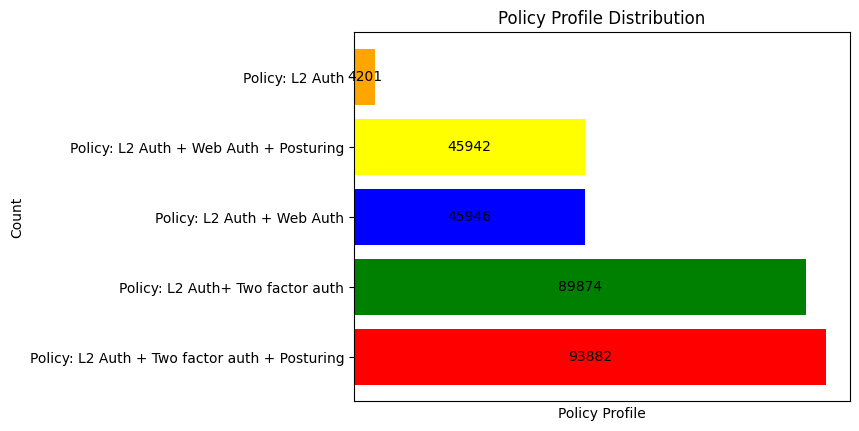

In [ ]:
# Create the bar plot

# Create a list of colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'orange']

# Calculate the counts of each policy profile
policy_counts = thousandeyes_df_sitetag['Policy-Profile'].value_counts()

# Create the bar plot
plt.barh(policy_counts.index, policy_counts.values, color=colors)


# Set labels and title
plt.xlabel('Policy Profile')
plt.ylabel('Count')
plt.title('Policy Profile Distribution')

# Remove the x-axis labels
plt.xticks([])

# Add the count values inside the bars
for i, count in enumerate(policy_counts.values):
    plt.text(count/2, i, str(count), ha='center', va='center')


# Display the plot
plt.show()

### Write this file as Security score calculated file

In [ ]:
thousandeyes_df_sitetag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag_x             279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

In [ ]:
thousandeyes_df_sitetag.to_csv('/content/drive/MyDrive/Colab Notebooks/Thousand_Eyes_Calculated.csv', index=False)

# Clustering of Data

## Data scaling and one hot encoding

In [ ]:
thousandeyes_df_ML = thousandeyes_df_sitetag

In [ ]:
thousandeyes_df_ML.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_mac_x           279845 non-null  object        
 1   date                   279845 non-null  object        
 2   time                   279845 non-null  datetime64[ns]
 3   wlan                   279845 non-null  object        
 4   ap_name                279845 non-null  object        
 5   site_tag_x             279845 non-null  object        
 6   location               279845 non-null  int64         
 7   managed                279845 non-null  int64         
 8   mab                    279845 non-null  int64         
 9   dot1                   279845 non-null  int64         
 10  l3webauth              279845 non-null  int64         
 11  l2webauth              279845 non-null  int64         
 12  username               279845 non-null  obje

### Features to keep for ML
- ['Privilege-score', 'Device-score', 'Managed_score', 'Hour-Common', 'Site-Common', 'location_score', 'Security-Factor', 'Policy-Profile']

In [ ]:
len(thousandeyes_df_ML['ap_name'].unique())

1185

In [ ]:
print(thousandeyes_df_ML['ap_name'].unique())
print(thousandeyes_df_ML['Privilege-score'].unique())
print(thousandeyes_df_ML['Device-score'].unique())
print(thousandeyes_df_ML['Managed_score'].unique())
print(thousandeyes_df_ML['Hour-Common'].unique())
print(thousandeyes_df_ML['Site-Common'].unique())
print(thousandeyes_df_ML['location_score'].unique())
print(thousandeyes_df_ML['Security-Factor'].unique())
print(thousandeyes_df_ML['Policy-Profile'].unique())


['USXNASPE-AP03' 'USMIASPT-2-AP12' 'USXNASPE-AP02' ... 'USLAXS28-1-AP06'
 'USLAXS28-1-AP04' 'COBOGTEL-AP05']
[ 0 10]
[0 1]
[ 0 20]
[0 1]
[0 1]
[0 1]
[ 0  1 21 22  2 20 11 23 10 31 12 32 30  3 33 13 14 24 34  4]
['Policy: L2 Auth', 'Policy: L2 Auth+ Two factor auth', 'Policy: L2 Auth + Two factor auth + Posturing', 'Policy: L2 Auth + Web Auth', 'Policy: L2 Auth + Web Auth + Posturing']
Categories (5, object): ['Policy: L2 Auth', 'Policy: L2 Auth+ Two factor auth',
                         'Policy: L2 Auth + Web Auth', 'Policy: L2 Auth + Two factor auth + Posturing',
                         'Policy: L2 Auth + Web Auth + Posturing']


### Change Managed score and scale Security-Factor

In [ ]:
#thousandeyes_df_ML['Managed_score'] = thousandeyes_df_ML['Managed_score'].replace(20, 1)

In [ ]:
#print(thousandeyes_df_ML['Managed_score'].unique())

In [ ]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape the data to a 2D array as expected by MinMaxScaler
data_reshaped = thousandeyes_df_ML['Security-Factor'].values.reshape(-1, 1)
#data_reshaped1 = thousandeyes_df_ML['Managed_score'].values.reshape(-1, 1)

# Scale the data
scaled_data = scaler.fit_transform(data_reshaped)
#scaled_data1 = scaler.fit_transform(data_reshaped1)

# Assign the scaled values back to the 'Security-Factor' column
thousandeyes_df_ML['Security-Factor'] = scaled_data
#thousandeyes_df_ML['Managed_score'] = scaled_data1

# Print the updated DataFrame
print(thousandeyes_df_ML['Security-Factor'].value_counts())
#print(thousandeyes_df_ML['Managed_score'].value_counts())

0.058824    44925
0.647059    44558
0.617647    26608
0.029412    26608
0.352941    20871
0.941176    20792
0.676471    17280
0.088235    17186
0.970588    11914
0.382353    11773
0.323529    10690
0.911765    10672
0.588235     4234
0.000000     4201
0.882353     1537
0.294118     1528
0.705882     1202
0.117647     1155
0.411765     1084
1.000000     1027
Name: Security-Factor, dtype: int64


In [ ]:
thousandeyes_model_df = thousandeyes_df_ML[['Privilege-score', 'Device-score', 'Managed_score', 'Hour-Common', 'Site-Common', 'location_score', 'Security-Factor', 'Policy-Profile']].copy()

In [ ]:
thousandeyes_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279845 entries, 0 to 279844
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Privilege-score  279845 non-null  int64   
 1   Device-score     279845 non-null  int64   
 2   Managed_score    279845 non-null  int64   
 3   Hour-Common      279845 non-null  int64   
 4   Site-Common      279845 non-null  int64   
 5   location_score   279845 non-null  int64   
 6   Security-Factor  279845 non-null  float64 
 7   Policy-Profile   279845 non-null  category
dtypes: category(1), float64(1), int64(6)
memory usage: 17.3 MB


In [ ]:
thousandeyes_model_df.shape

(279845, 8)

# Machine Learning Algorithms

## Decision Tree with "gini"

In [ ]:
X = thousandeyes_model_df.drop('Policy-Profile', axis=1)
Y = thousandeyes_model_df['Policy-Profile']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train, Y_train)

DecisionTreeClassifier()

In [ ]:
Y_pred = clf.predict(X_test)

In [ ]:
X_test.shape

(55969, 7)

In [ ]:
Sample_1 = X_test.iloc[9, :]

In [ ]:
specific_indices = [3, 14]  # Indices of the specific samples in X_test

specific_inputs = X_test.iloc[specific_indices, :]  # Select the specific samples from X_test

predicted_outputs = clf.predict(specific_inputs)
print(predicted_outputs)

['Policy: L2 Auth + Two factor auth + Posturing'
 'Policy: L2 Auth + Web Auth + Posturing']


In [ ]:
print(specific_inputs)

        Privilege-score  Device-score  Managed_score  Hour-Common  \
271008                0             0             20            0   
36962                10             0             20            1   

        Site-Common  location_score  Security-Factor  
271008            1               1         0.647059  
36962             1               1         0.970588  


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 1.0
Classification Report:
                                                precision    recall  f1-score   support

                              Policy: L2 Auth       1.00      1.00      1.00       862
Policy: L2 Auth + Two factor auth + Posturing       1.00      1.00      1.00     18838
                   Policy: L2 Auth + Web Auth       1.00      1.00      1.00      9119
       Policy: L2 Auth + Web Auth + Posturing       1.00      1.00      1.00      9140
             Policy: L2 Auth+ Two factor auth       1.00      1.00      1.00     18010

                                     accuracy                           1.00     55969
                                    macro avg       1.00      1.00      1.00     55969
                                 weighted avg       1.00      1.00      1.00     55969



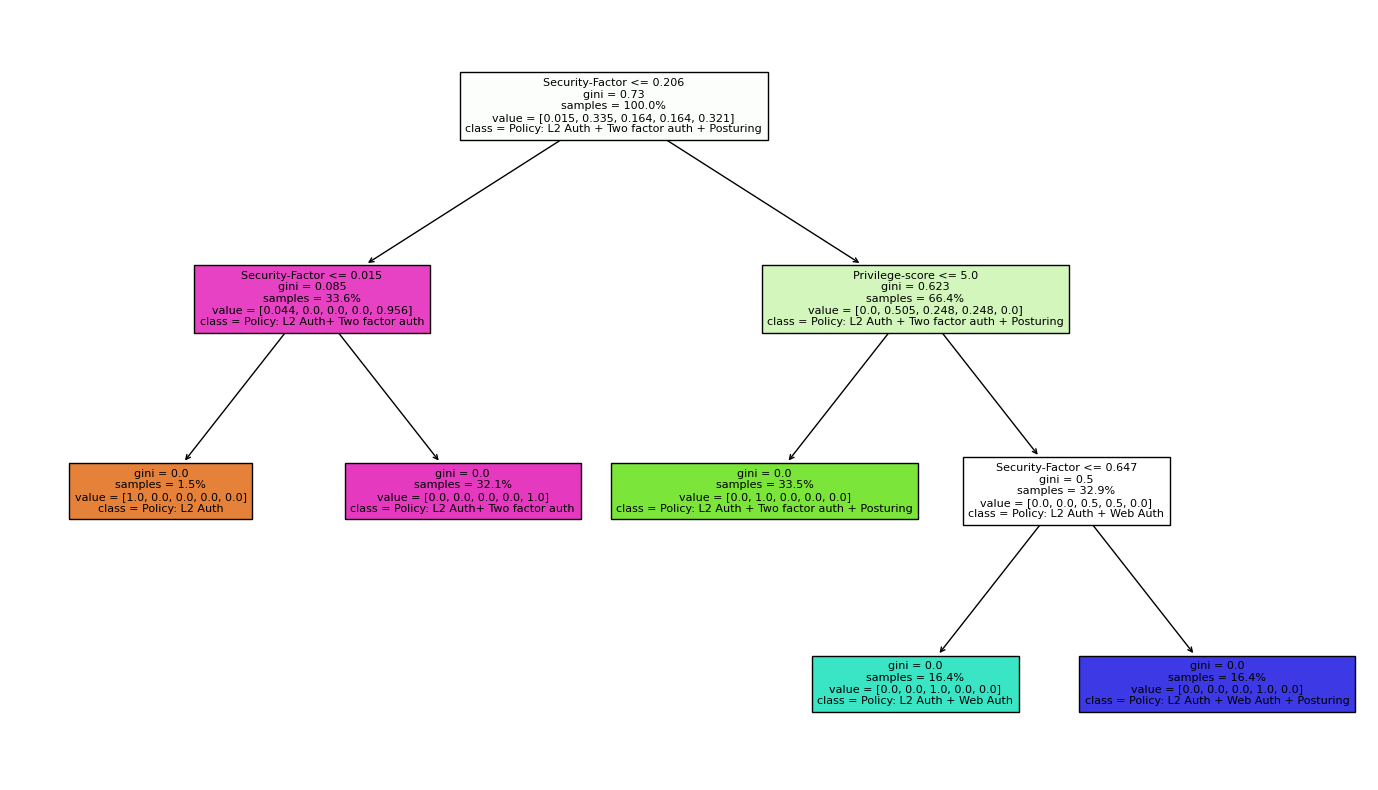

In [ ]:
from sklearn import tree
# Plot the decision tree
plt.figure(figsize=(14, 8))
tree.plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_, filled=True, fontsize=8, proportion=True)

plt.tight_layout()  # Add padding between subplots for better spacing

plt.show()

## Predicting the Policy Profile based on user given input

### 3 samples collected for same username based on user context (who, when, where, what)

In [ ]:
thousandeyes_test_data = pd.read_csv( "/content/drive/MyDrive/Colab Notebooks/Test-Username.csv" )

In [ ]:
thousandeyes_test_data.rename(columns={"Policy-Profile": "Expected-Policy-Profile"}, inplace=True)

In [ ]:
thousandeyes_test_data["ML_Predicted_Policy_Profile"] = None

In [ ]:
thousandeyes_test_data

,client_mac_x,username,Privilege-score,Device-score,Managed_score,Hour-Common,Site-Common,location_score,Security-Factor,Expected-Policy-Profile,ML_Predicted_Policy_Profile
0,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,0,0,0,0,0.000000,Policy: L2 Auth,None
1,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,20,0,0,0,0.588235,Policy: L2 Auth + Two factor auth + Posturing,None
2,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,0,0,0,1,0.029412,Policy: L2 Auth+ Two factor auth,None


In [ ]:
thousandeyes_test_input = thousandeyes_test_data[['Privilege-score','Device-score', 'Managed_score', 'Hour-Common', 'Site-Common', 'location_score', 'Security-Factor']].copy()

In [ ]:
Thousand_Eyes_outputs = clf.predict(thousandeyes_test_input)

In [ ]:
print("Username:", thousandeyes_test_data.username[0], "joined with usual device, not a guest user, org managed device,")
print("usual time, usual place in office and location is office.\n")
print("Username:", thousandeyes_test_data.username[0], "ML engine predicted and assigned Policy Profile->", Thousand_Eyes_outputs[0])

Username: (svc_7signal_cert@spe.sony.com) joined with usual device, not a guest user, org managed device,
usual time, usual place in office and location is office.

Username: (svc_7signal_cert@spe.sony.com) ML engine predicted and assigned Policy Profile-> Policy: L2 Auth


In [ ]:
print("Username:", thousandeyes_test_data.username[1], "joined with usual device, not a guest user, org un-managed device (mobile),")
print("usual time, usual place in office and location is office.\n")
print("Username:", thousandeyes_test_data.username[1], "ML engine predicted and assigned Policy Profile->", Thousand_Eyes_outputs[1])

Username: (svc_7signal_cert@spe.sony.com) joined with usual device, not a guest user, org un-managed device (mobile),
usual time, usual place in office and location is office.

Username: (svc_7signal_cert@spe.sony.com) ML engine predicted and assigned Policy Profile-> Policy: L2 Auth + Two factor auth + Posturing


In [ ]:
print("Username:", thousandeyes_test_data.username[2], "joined with usual device, not a guest user, org managed device,")
print("usual time, OEAP and location is home.\n")
print("Username:", thousandeyes_test_data.username[2], "ML engine predicted and assigned Policy Profile->", Thousand_Eyes_outputs[2])

Username: (svc_7signal_cert@spe.sony.com) joined with usual device, not a guest user, org managed device,
usual time, OEAP and location is home.

Username: (svc_7signal_cert@spe.sony.com) ML engine predicted and assigned Policy Profile-> Policy: L2 Auth+ Two factor auth


In [ ]:
thousandeyes_test_data["ML_Predicted_Policy_Profile"] = clf.predict(thousandeyes_test_input)

In [ ]:
thousandeyes_test_data

,client_mac_x,username,Privilege-score,Device-score,Managed_score,Hour-Common,Site-Common,location_score,Security-Factor,Expected-Policy-Profile,ML_Predicted_Policy_Profile
0,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,0,0,0,0,0.000000,Policy: L2 Auth,Policy: L2 Auth
1,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,20,0,0,0,0.588235,Policy: L2 Auth + Two factor auth + Posturing,Policy: L2 Auth + Two factor auth + Posturing
2,04f0.2185.62d8,(svc_7signal_cert@spe.sony.com),0,0,0,0,0,1,0.029412,Policy: L2 Auth+ Two factor auth,Policy: L2 Auth+ Two factor auth


In [ ]:
print("We can see that the Expected-Policy-Profile and ML predicted policy profile are matching")

We can see that the Expected-Policy-Profile and ML predicted policy profile are matching


## KMeans applied with number of clusters defined on original dataset without Y variable which contained the policy profile names

In [ ]:
no_clusters = 5

In [ ]:
# Apply K-means
#kmeans = KMeans(n_clusters=no_clusters)  # Specify the number of clusters
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=1000, random_state=42)

kmeans_labels = kmeans.fit_predict(X)

In [ ]:
# Access the inertia (sum of squared distances)
inertia = kmeans.inertia_
print(inertia)

168857.46476095804


In [ ]:
thousandeyes_model_df['KMeans_labels'] = kmeans_labels

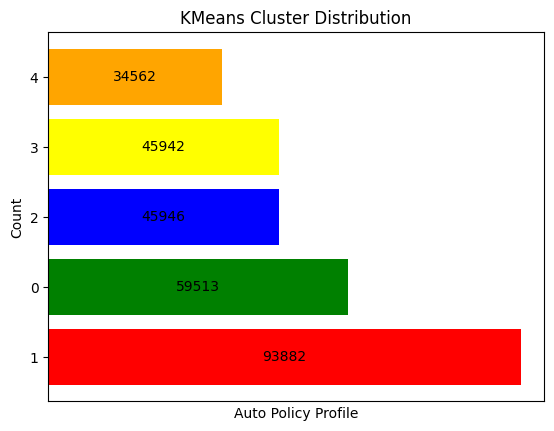

In [ ]:
# Create the bar plot

# Create a list of colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'orange']

# Calculate the counts of each policy profile
kmeans_cluster = thousandeyes_model_df['KMeans_labels'].value_counts()

# Convert index values to strings
cluster_labels1 = kmeans_cluster.index.astype(str)

# Create the bar plot
plt.barh(cluster_labels1, kmeans_cluster.values, color=colors)


# Set labels and title
plt.xlabel('Auto Policy Profile')
plt.ylabel('Count')
plt.title('KMeans Cluster Distribution')

# Remove the x-axis labels
plt.xticks([])

# Add the count values inside the bars
for i, count in enumerate(kmeans_cluster.values):
    plt.text(count/2, i, str(count), ha='center', va='center')


# Display the plot
plt.show()

## Will try and cluster without calculating Security-Factor

In [ ]:
thousandeyes_model_unsupervised_df = thousandeyes_df_ML[['Privilege-score','Device-score', 'Managed_score', 'Hour-Common', 'Site-Common', 'location_score']].copy()

In [ ]:
kmeans1 = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=1000, random_state=42)

kmeans_labels1 = kmeans1.fit_predict(thousandeyes_model_unsupervised_df)

In [ ]:
thousandeyes_model_unsupervised_df['KMeans_labels'] = kmeans_labels1

In [ ]:
# Calculate the counts of each cluster
kmeans_cluster_counts = thousandeyes_model_unsupervised_df['KMeans_labels'].value_counts()

# Convert index values to strings
cluster_labels = kmeans_cluster_counts.index.astype(str)

# Create a list of colors for each bar
colors = ['red', 'green', 'blue', 'yellow', 'orange']


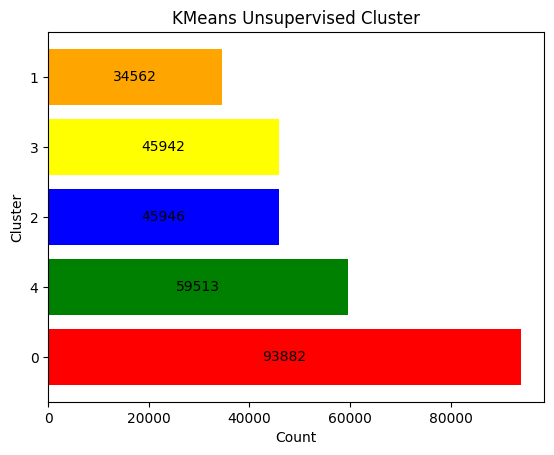

In [ ]:
# Create the bar plot
plt.barh(cluster_labels, kmeans_cluster_counts.values, color=colors)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Cluster')
plt.title('KMeans Unsupervised Cluster')

# Add the count values inside the bars
for i, count in enumerate(kmeans_cluster_counts.values):
    plt.text(count/2, i, str(count), ha='center', va='center')

# Display the plot
plt.show()


### Save the model file to .csv

In [ ]:
thousandeyes_model_unsupervised_df.to_csv('/content/drive/MyDrive/Colab Notebooks/model-output.csv', index=False)

## Apply DBSCAN for unsupervised clustering

In [ ]:
# Create a DBSCAN object
#dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the DBSCAN model to your data
#dbscan.fit(thousandeyes_model_unsupervised_df)

# Retrieve the labels assigned to each data point
#labels = dbscan.labels_

In [ ]:
# Retrieve the core samples and their indices
#core_samples_mask = np.zeros_like(labels, dtype=bool)
#core_samples_mask[dbscan.core_sample_indices_] = True

# Print the labels and core samples
#print("Cluster labels:", labels)
#print("Core samples:", core_samples_mask)

## Hierarchical Clustering

In [ ]:
#import numpy as np
#from sklearn.cluster import AgglomerativeClustering
#from sklearn.datasets import make_blobs
#import matplotlib.pyplot as plt

# Generate random data
#X, y = make_blobs(n_samples=100, centers=3, random_state=42)

# Perform hierarchical clustering
#clustering = AgglomerativeClustering(n_clusters=5)
#clustering.fit(thousandeyes_model_unsupervised_df)

# Plot the data points with color-coded clusters
#plt.scatter(X[:, 0], X[:, 1], c=clustering.labels_, cmap='viridis')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.title('Hierarchical Clustering')
#plt.show()


# End